# Exercise - Survival function and hazard function
- The aim of this exercise is to calculate the survival rate and hazard rate as a function of time, based on a neurology cohort. A better prediction of suvival rate should involve a study of more features 
- For confidential purpose, this code does not show any other information than needed (no data exploration part)

In [119]:
import pandas as pd
import numpy as np
import os 
import matplotlib.pyplot as plt
import seaborn as sns

In [120]:
cwd = os.getcwd()
data_bio = pd.read_excel(cwd + r'\données biologiques.xlsx')
data_clinic = pd.read_excel(cwd + r'\données cliniques.xls')

### Data cleanning

In [121]:
data0 = data_bio.merge(data_clinic, on ='NIP' )
data = data0.replace(to_replace = 'N/C', value = np.nan)
data = data.replace(to_replace = 'normal',value = 'Normal')
data = data.replace(to_replace = {'non penon perte': 'non perte',
                                  'non pertenon perte': 'non perte',
                                  'non perte\nnon perte': 'non perte'})
data['chir_date']= pd.to_datetime(data['chir_date']) 
data.loc[data['date_evolution'] == '2099-12-29', 'date_evolution'] = pd.to_datetime('2009-12-29')
data.dropna(subset = ['chir_date'], axis = 0, inplace = True) # drop rows where chir_date is NaN

- Add end time of observation  
suppose that we can only observe data up until the end of 2013 (we verified that the latest data in the data set is 2013-03-19)

In [122]:
data.select_dtypes(include = 'datetime').max().max()

Timestamp('2013-03-19 00:00:00')

In [123]:
end_date = pd.to_datetime('2013-12-31')

- There are 3 types of patient: 
1. patient already dead: days before death known
2. patient lost: days before death not known, days before lost known, use days before lost as censoring time 
3. patient still alive: days before death not known, days before lost not known, in this case, use obs days for the censoring time

In [124]:
# create variable 'days before death'
data['days_before_death'] = (data['date_deces']-data['chir_date']).dt.days
# create variable 'obs_days' for the # days under observation
data['obs_days'] = (end_date - data['chir_date']).dt.days
# create vraible 'days_before_lost' for the # of days before we lose the patient for any reasons
data['days_before_lost'] = (data['DN_date'] - data['chir_date']).dt.days

### Survival function, hazard function
- Survival function S(t) represents the probability of a subject survives beyond time t  
- Hazard function h(t) represents the probability of a subject survives at time t+1 if he is alive at time t  

In [125]:
max_year = int(data['obs_days'].max()/365)+1
survival_df = pd.DataFrame([],columns = ['censored','dead','still_in','survival','hazard'])
survival_df.loc[0] = [0,0,len(data.index),1.0,1.0]
for yr in range(1,max_year+1):
    start_day = (yr-1)*365
    end_day = (yr)*365
    delta_censored = (((data['days_before_death'].isna()) & (data['days_before_lost'] >= start_day) & (data['days_before_lost'] < end_day)) |
                      ((data['days_before_death'].isna()) & (data['days_before_lost'].isna()) & (data['obs_days'] >= start_day) & (data['obs_days'] < end_day))).sum()
    delta_dead = ((data['days_before_death'] >= start_day) & (data['days_before_death'] < end_day)).sum()
    censored = survival_df.loc[yr-1,'censored'] + delta_censored
    dead = survival_df.loc[yr-1,'dead'] + delta_dead
    still_in = survival_df.loc[yr-1,'still_in']  - delta_censored - delta_dead
    if survival_df.loc[yr-1,'still_in'] == 0:
        hazard = 1.0
    else:
        hazard = 1 - delta_dead / survival_df.loc[yr-1,'still_in']
    if survival_df.loc[yr-1,'still_in'] == delta_censored:
        survival = 0.0
    else:
        survival = survival_df.loc[yr-1,'survival'] * ( (survival_df.loc[yr-1,'still_in'] - delta_censored - delta_dead) / (survival_df.loc[yr-1,'still_in'] - delta_censored))
    survival_df.loc[yr] = [censored,dead, still_in, survival, hazard]

# below are codes used to do sanity check
# print(data.shape)
# print(survival_df.head(15))
# (~data['days_before_death'].isna()).sum() # for number of subjects already dead during the whole observation period
# ((data['days_before_death']/365).dropna()).astype('int').value_counts() # to cross check with survival_df['dead']


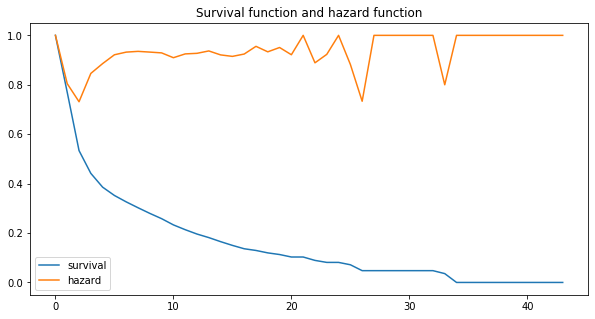

In [126]:
plt.figure(figsize = (10,5))
survival_df['survival'].plot()
survival_df['hazard'].plot()
plt.legend()
plt.title('Survival function and hazard function')
plt.show()

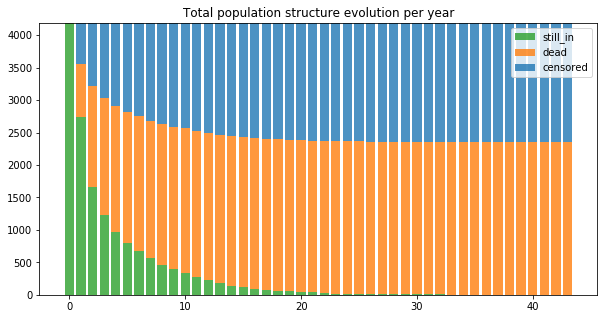

In [128]:
plt.figure(figsize = (10,5))
p3 = plt.bar(survival_df.index.to_list(),survival_df['censored'],bottom = (survival_df['dead'] + survival_df['still_in']),alpha = 0.8)
p2 = plt.bar(survival_df.index.to_list(),survival_df['dead'],bottom = survival_df['still_in'],alpha = 0.8)
p1 = plt.bar(survival_df.index.to_list(),survival_df['still_in'],alpha = 0.8)
plt.legend((p1[0],p2[0],p3[0]),('still_in','dead','censored'))
plt.title('Total population structure evolution per year')
plt.show()